### Zadanie: porównanie metod klasteringu

Zajmiemy zbiorem danych z telefonów Samsung, dotyczących aktywności fizycznej.

Dane są zebrane w pliku Samsung_HAR.zip. Należy je rozpakować i przeanalizować.

Obróbka danych wejściowych:

Czy potrzeba wszystkich cech?

Czy potrzebna jest jakaś obróbka?

Czy wiemy, jak obrobić?

Czy wiemy, co jaka cecha znaczy?

Czy potrzebujemy aż dwóch plików?

Pamiętajmy, że mamy do czynienia z Unsupervised Learning. Czy podział na dane testowe i treningowe jest potrzebny, jeśli tak to dlaczego, jeśli nie to dlaczego?

Do zrobienia:

Użyj poznanych metod klasteringu, aby podzielić dany zbiór (pamiętaj o skalowaniu itp.).

Zwizualizuj podział przez każdy algorytm (możesz użyć metod z notatników).

Z jakim typem czynności algorytmy poradziły sobie super, z jakim nie najlepiej. Typy czynności (dane zawarte w plikach *labels):

1 – marsz

2 – wchodzenie w górę po schodach

3 – schodzenie w dół ze schodów

4 – siedzenie

5 – stanie

6 – leżenie

Dobierz prawidłową ilość klastrów w przypadku metody KMeans.

Na danym zbiorze dokonaj preprocessingu, używając metod klasteringu. Następnie wyszkol dwa wybrane przez siebie klasyfikatory typu Supervised Learning i spróbuj uzyskać jak najlepszy wynik, używając wszystkich znanych sobie "wspomagaczy".

W przypadku użycia train_test_split albo KFold/StratifiedKFold, możemy połączyć zbiory, gdyż i tak wydzielamy zbiór walidacyjny.

Chyba że chcemy mieć dodatkowy zbiór testowy do przetestowania modeli po wyszkoleniu. Chcemy?

Ideą klasteringu jest podział na podgrupy, czyli tutaj oczekujemy, że nasze algorytmy podzielą zbiór na 6 wspomnianych klastrów: marsz, wchodzenie/schodzenie po schodach, siedzenie, stanie, leżenie. Zbadaj, jak są porozrzucane w różnych klastrach. Im bardziej są rozrzucone, tym algorytm gorzej sobie z nimi radzi. Ideałem jest: jeden klaster, jedna czynność.

Na koniec pytanie, na które należy również odpowiedzieć, a które pojawia się zawsze podczas rozmów kwalifikacyjnych:

czym różni się KMeans, K-fold i K Nearest Neighbors (o tym ostatnim trzeba doczytać).
Rozwiązanie prześlij Mentorowi.

### Obróbka danych wejściowych:

Czy potrzeba wszystkich cech? - Nie, tych z bardzo dużymi brakami nie potrzebujemy.

Czy potrzebna jest jakaś obróbka? - Tak, potrzebna jest obróbka danych.

Czy wiemy, jak obrobić? - Tak, muszimy z pliku txt zorbić DF, żeby można je było obrobić. Usunąć należy również kolumny, które mają zbyt mało danych

Czy wiemy, co jaka cecha znaczy? - Nie wiemy, cachy nie mają nagłówków, nie wiemy dlaczego są liczby ujemne.

Czy potrzebujemy aż dwóch plików? - Tak, potrzebujemy dwóch plików train i test, które połączymy, żeby mieć więcej danych.

Pamiętajmy, że mamy do czynienia z Unsupervised Learning. Czy podział na dane testowe i treningowe jest potrzebny, jeśli tak to dlaczego, jeśli nie to dlaczego? - Podział plików na dane testowe i treningowe nie jest potrzebny, ponieważ w Unsupervised Learning nie ma nauczyciela


In [365]:
# manipulacja danymi
import numpy as np
import pandas as pd

# wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns

# podział danych na zbiory treningowe/walidacyjne/testowe
from sklearn.model_selection import train_test_split, GridSearchCV

# budowa Pipeline
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer

# redukcja wymiarowości
from sklearn.decomposition import PCA

In [366]:
data_train = open('samsung_train.txt')
data_test = open('samsung_test.txt')
linie_train=data_train.readlines()
linie_test=data_test.readlines()

print('liczba wierszy w pliku train={}'.format(len(linie_train)))
print('liczba wierszy w pliku test={}'.format(len(linie_test)))

liczba wierszy w pliku train=7352
liczba wierszy w pliku test=2947


In [367]:
with open('samsung_train.txt') as temp_f:
    col_count = [ len(l.split(" ")) for l in temp_f.readlines() ]

column_names = [i for i in range(max(col_count))] 

data_train = pd.read_csv('samsung_train.txt', sep=' ', header = None, names=column_names )
data_train.head()

,0,1,2,3,4,5,6,7,8,9,...,924,925,926,927,928,929,930,931,932,933
0,NaN,NaN,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [368]:
with open('samsung_test.txt') as temp_f:
    col_count = [ len(l.split(" ")) for l in temp_f.readlines() ]

column_names = [i for i in range(max(col_count))] 

data_test = pd.read_csv('samsung_test.txt', sep=' ', header = None, names=column_names )
data_test.head()

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,NaN,NaN,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [369]:
data = pd.concat([data_train, data_test])
data.head()

,0,1,2,3,4,5,6,7,8,9,...,924,925,926,927,928,929,930,931,932,933
0,NaN,NaN,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [370]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10299 entries, 0 to 2946
Columns: 934 entries, 0 to 933
dtypes: float64(934)
memory usage: 73.5 MB


In [371]:
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)
data.columns = range(data.columns.size)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,924,925,926,927,928,929,930,931,932,933
0,NaN,NaN,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [372]:
labels_train = open('samsung_train_labels.txt')
labels_test = open('samsung_test_labels.txt')
linie_train=labels_train.readlines()
linie_test=labels_test.readlines()

print('liczba wierszy w pliku train={}'.format(len(linie_train)))
print('liczba wierszy w pliku test={}'.format(len(linie_test)))

liczba wierszy w pliku train=7352
liczba wierszy w pliku test=2947


In [373]:
labels_train = pd.read_csv('samsung_train_labels.txt', header = None)
labels_train.head()

,0
0,5
1,5
2,5
3,5
4,5


In [374]:
labels_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       7352 non-null   int64
dtypes: int64(1)
memory usage: 57.6 KB


In [375]:
labels_test = pd.read_csv('samsung_test_labels.txt', header = None)
labels_test.head()

,0
0,5
1,5
2,5
3,5
4,5


In [376]:
labels_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       2947 non-null   int64
dtypes: int64(1)
memory usage: 23.1 KB


In [377]:
labels_train.columns = ['target']
labels_test.columns = ['target']
target = pd.concat([labels_train, labels_test])
target.head()

,target
0,5
1,5
2,5
3,5
4,5


In [378]:
target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10299 entries, 0 to 2946
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  10299 non-null  int64
dtypes: int64(1)
memory usage: 160.9 KB


In [379]:
target.reset_index(inplace=True)
target.drop(['index'], axis=1, inplace=True)
target.head()

,target
0,5
1,5
2,5
3,5
4,5


In [380]:
dataset=pd.concat([data, target], axis=1)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,925,926,927,928,929,930,931,932,933,target
0,NaN,NaN,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
1,NaN,NaN,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
2,NaN,NaN,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3,NaN,NaN,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
4,NaN,NaN,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


In [382]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10299 entries, 0 to 10298
Columns: 935 entries, 0 to target
dtypes: float64(934), int64(1)
memory usage: 73.5 MB


In [383]:
dataset.drop_duplicates(inplace=True)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,925,926,927,928,929,930,931,932,933,target
0,NaN,NaN,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
1,NaN,NaN,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
2,NaN,NaN,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3,NaN,NaN,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
4,NaN,NaN,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


In [384]:
dataset.dropna(thresh=1, axis=1, inplace=True)
dataset.head()

,1,2,3,4,5,6,7,8,9,10,...,921,922,923,924,926,928,929,931,933,target
0,NaN,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
1,NaN,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
2,NaN,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3,NaN,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
4,NaN,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


In [394]:
print(dataset.isnull().sum(axis=1).max())

361


In [397]:
tresh = ((dataset.columns.size) - (dataset.isnull().sum(axis=1).max()))

In [398]:
dataset.dropna(thresh=tresh, inplace=True)
dataset.head()

,1,2,3,4,5,6,7,8,9,10,...,921,922,923,924,926,928,929,931,933,target
0,NaN,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
1,NaN,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
2,NaN,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3,NaN,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
4,NaN,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


In [399]:
dataset.fillna(0, inplace=True)

In [400]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10299 entries, 0 to 10298
Columns: 923 entries, 1 to target
dtypes: float64(922), int64(1)
memory usage: 72.6 MB


<AxesSubplot: >

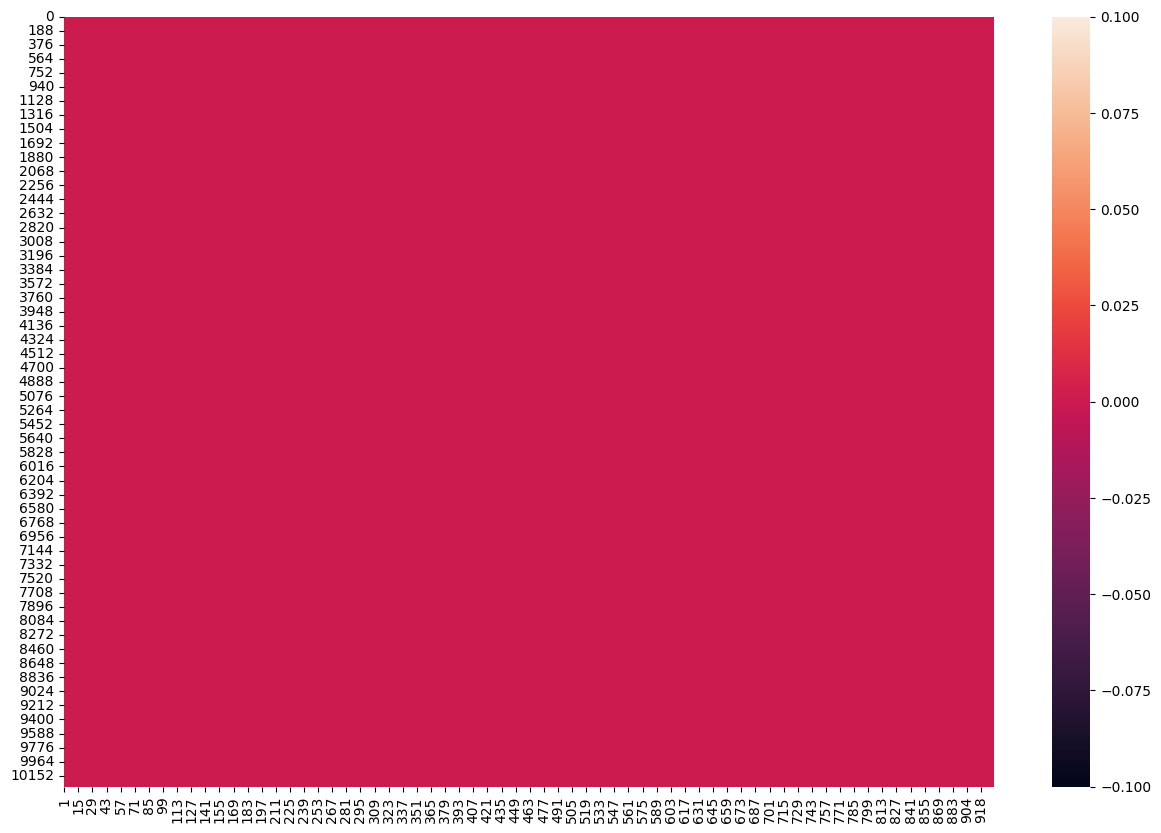

In [401]:
plt.figure(figsize=(15,10))
sns.heatmap(dataset.isnull())

In [402]:
dataset.reset_index(inplace=True)
dataset.drop(['index'], axis=1, inplace=True)
dataset.columns = range(dataset.columns.size)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,913,914,915,916,917,918,919,920,921,922
0,0.0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,0.0,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
3,0.0,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
4,0.0,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [403]:
from pandas import RangeIndex
columns = RangeIndex(start=0, stop=922, step=1)
X = dataset[columns]
y = dataset[922]
print('X:')
display(X)
print('\ny:')
display(y)

X:


,0,1,2,3,4,5,6,7,8,9,...,912,913,914,915,916,917,918,919,920,921
0,0.0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10294,0.0,0.310155,-0.053391,-0.099109,-0.287866,-0.140589,-0.215088,-0.356083,-0.148775,-0.232057,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10295,0.0,0.363385,-0.039214,-0.105915,-0.305388,0.000000,0.028148,-0.196373,-0.373540,-0.030036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10296,0.0,0.349966,0.000000,0.030077,-0.115788,-0.329638,-0.042143,-0.250181,-0.388017,-0.133257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10297,0.0,0.237594,0.000000,0.018467,-0.096499,-0.323114,-0.229775,-0.207574,-0.392380,-0.279610,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



y:


0        5
1        5
2        5
3        5
4        5
        ..
10294    2
10295    2
10296    2
10297    2
10298    2
Name: 922, Length: 10299, dtype: int64

In [405]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict

# stworzenie klasyfikatora
clf = SGDClassifier(random_state=1)

# użycie metody cross_val_score do sprawdzenia
# działania naszego modelu na różnych podziałach
cv_score = cross_val_score(clf, X, y, cv=5)
print("wynik kroswalidacji: ", cv_score)
print("średni wynik wszystkich foldów: ", cv_score.mean())

wynik kroswalidacji:  [0.82427184 0.75776699 0.82815534 0.81262136 0.83827101]
średni wynik wszystkich foldów:  0.8122173078645962


In [406]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

#Przykład podziału za pomocą stratyfikacji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                    random_state=3, stratify=y)
# summarize
train_1, train_2, train_3, train_4, train_5, train_6 = len(y_train[y_train==1]), len(y_train[y_train==2]), len(y_train[y_train==3]), len(y_train[y_train==4]), len(y_train[y_train==5]), len(y_train[y_train==6])
test_1, test_2, test_3, test_4, test_5, test_6 = len(y_test[y_test==1]), len(y_test[y_test==2]), len(y_test[y_test==3]), len(y_test[y_test==4]), len(y_test[y_test==5]), len(y_test[y_test==6])

print('>Train: 1=%d, 2=%d, 3=%d, 4=%d,5=%d, 6=%d, Test: 1=%d, 2=%d, 3=%d, 4=%d,5=%d, 6=%d' % (train_1, train_2, train_3, train_4, train_5, train_6, test_1, test_2, test_3, test_4, test_5, test_6))

>Train: 1=1378, 2=1235, 3=1125, 4=1421,5=1525, 6=1555, Test: 1=344, 2=309, 3=281, 4=356,5=381, 6=389


In [407]:
def plot_clusters(X, y=None):
    plt.figure(figsize=(15, 10))
    plt.scatter(X[:, 4], X[:, 5], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=15)
    plt.ylabel("$x_2$", fontsize=15, rotation=0)
    plt.grid()

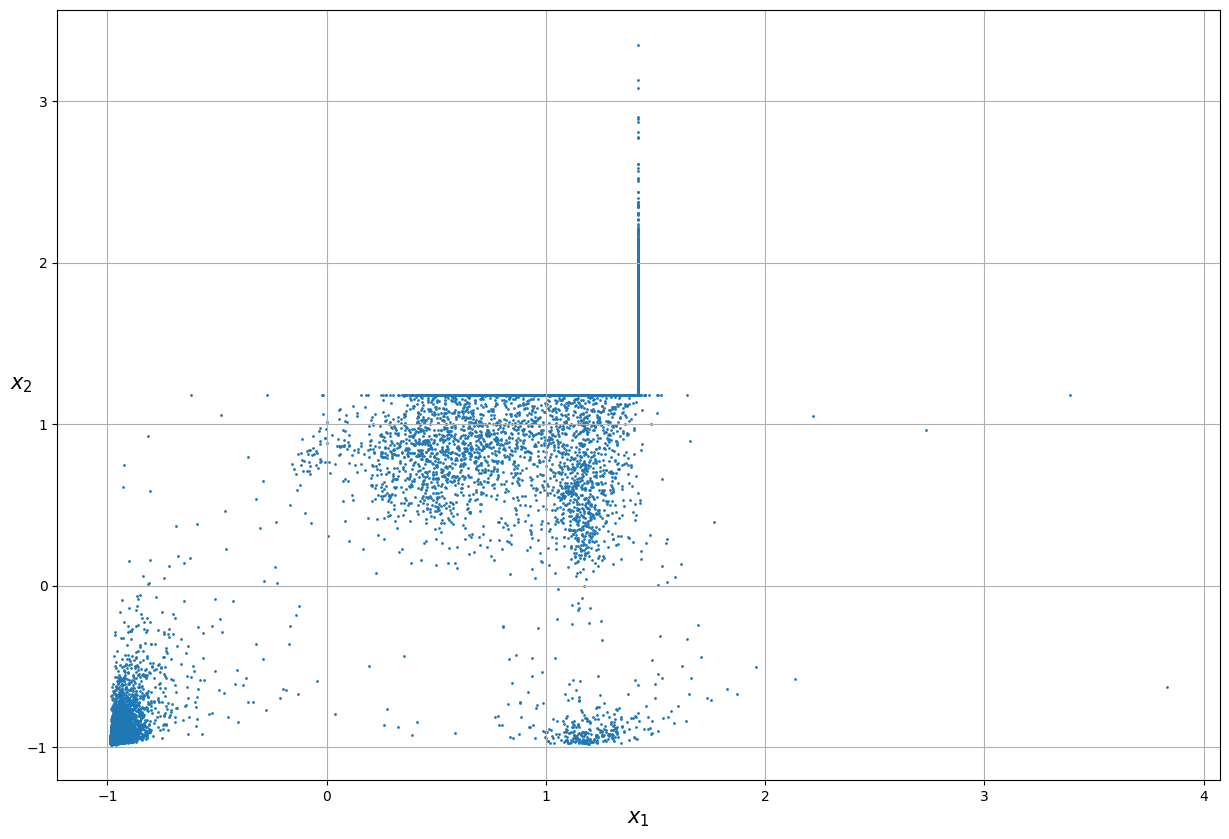

In [442]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(X)
plot_clusters(X)

In [410]:
display(X)

array([[ 0.04927216,  0.21671799,  0.00746665, ...,  0.00985425,
        -0.00985425, -0.00985425],
       [ 0.04927216,  0.05522904,  0.1680671 , ...,  0.00985425,
        -0.00985425, -0.00985425],
       [ 0.04927216,  0.07483565,  0.04166659, ...,  0.00985425,
        -0.00985425, -0.00985425],
       ...,
       [ 0.04927216,  1.1918074 ,  0.84670101, ...,  0.00985425,
        -0.00985425, -0.00985425],
       [ 0.04927216, -0.59330469,  0.84670101, ...,  0.00985425,
        -0.00985425, -0.00985425],
       [ 0.04927216, -1.9271736 ,  0.08428754, ...,  0.00985425,
        -0.00985425, -0.00985425]])

In [449]:
X = dataset[columns]
display(X)

,0,1,2,3,4,5,6,7,8,9,...,912,913,914,915,916,917,918,919,920,921
0,0.0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10294,0.0,0.310155,-0.053391,-0.099109,-0.287866,-0.140589,-0.215088,-0.356083,-0.148775,-0.232057,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10295,0.0,0.363385,-0.039214,-0.105915,-0.305388,0.000000,0.028148,-0.196373,-0.373540,-0.030036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10296,0.0,0.349966,0.000000,0.030077,-0.115788,-0.329638,-0.042143,-0.250181,-0.388017,-0.133257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10297,0.0,0.237594,0.000000,0.018467,-0.096499,-0.323114,-0.229775,-0.207574,-0.392380,-0.279610,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [412]:
display(X)

,0,1,2,3,4,5,6,7,8,9,...,912,913,914,915,916,917,918,919,920,921
0,0.0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10294,0.0,0.310155,-0.053391,-0.099109,-0.287866,-0.140589,-0.215088,-0.356083,-0.148775,-0.232057,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10295,0.0,0.363385,-0.039214,-0.105915,-0.305388,0.000000,0.028148,-0.196373,-0.373540,-0.030036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10296,0.0,0.349966,0.000000,0.030077,-0.115788,-0.329638,-0.042143,-0.250181,-0.388017,-0.133257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10297,0.0,0.237594,0.000000,0.018467,-0.096499,-0.323114,-0.229775,-0.207574,-0.392380,-0.279610,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [413]:
# import odpowiedniej biblioteki
from sklearn.cluster import KMeans

clf = KMeans(n_clusters=6)

# możemy uzyć metod fit(), predict() 
clf.fit(X)
y_pred = clf.predict(X)

#albo metody fit/predict, która łączy dwie powyższe

y_pred = clf.fit_predict(X)
print(y_pred)

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 5 5 ... 3 3 3]


In [414]:
clf.cluster_centers_

array([[-3.10656753e-03,  2.67206775e-01, -2.33467747e-02, ...,
        -6.77626358e-20, -2.71050543e-20,  2.37169225e-20],
       [-8.17857665e-04,  2.76976180e-01, -1.69691009e-02, ...,
        -2.84603070e-19,  1.01643954e-20,  6.77626358e-20],
       [-1.10716190e-04,  2.76475305e-01, -1.90214536e-02, ...,
        -2.57498016e-19,  0.00000000e+00,  6.09863722e-20],
       [-1.11207604e-03,  2.70335670e-01, -2.36502448e-02, ...,
        -1.35525272e-19, -2.03287907e-20,  4.06575815e-20],
       [-1.95199713e-03,  2.82520136e-01, -2.30441848e-02, ...,
        -5.06281786e-04,  1.70753543e-04,  1.18433336e-04],
       [-2.92395392e-04,  2.76788902e-01, -1.80047166e-02, ...,
         6.77626358e-20, -6.09863722e-20, -3.38813179e-21]])

In [415]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=3, linewidths=8,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(klasyfikator, X):
    # wyznaczanie granic decyzyjnych, podobnie jak w poprzednich notatnikach
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 100),
                         np.linspace(mins[1], maxs[1], 100))
    Z = klasyfikator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # rysowanie konturów granic 
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    
    # rysowanie danych
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    # centra klastrów można wyciągnąc za pomocą zmiennej cluster_centers_
    plot_centroids(klasyfikator.cluster_centers_)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

In [447]:
clf = KMeans(n_clusters=6)

# możemy uzyć metod fit()
clf.fit(X)

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=6)

In [448]:
plt.figure(figsize=(10, 5))
plot_decision_boundaries(clf, X)
plt.show()

ValueError: X has 2 features, but KMeans is expecting 922 features as input.

<Figure size 1000x500 with 0 Axes>

In [419]:
clf.cluster_centers_

array([[-1.11207604e-03,  2.70335670e-01, -2.36502448e-02, ...,
        -1.35525272e-19, -1.69406589e-20,  4.06575815e-20],
       [-2.92395392e-04,  2.76788902e-01, -1.80047166e-02, ...,
         6.77626358e-20, -6.09863722e-20, -3.38813179e-21],
       [-8.17857665e-04,  2.76976180e-01, -1.69691009e-02, ...,
        -2.84603070e-19,  1.35525272e-20,  6.43745040e-20],
       [-1.95339241e-03,  2.82564732e-01, -2.30412549e-02, ...,
        -5.06643674e-04,  1.70875597e-04,  1.18517991e-04],
       [-1.10716190e-04,  2.76475305e-01, -1.90214536e-02, ...,
        -2.57498016e-19,  0.00000000e+00,  6.09863722e-20],
       [-3.10471948e-03,  2.67178770e-01, -2.33490332e-02, ...,
        -8.13151629e-20, -3.04931861e-20,  2.37169225e-20]])

In [420]:
# poszczególne kroki 

clf_1 = KMeans(n_clusters=6, max_iter=1, init="random", n_init=1, algorithm="lloyd", random_state=42)
clf_2 = KMeans(n_clusters=6, max_iter=2, init="random", n_init=1, algorithm="lloyd", random_state=42)
clf_3 = KMeans(n_clusters=6, max_iter=3, init="random", n_init=1, algorithm="lloyd", random_state=42)
clf_300 = KMeans(n_clusters=6, max_iter=300, init="random", n_init=1, algorithm="lloyd", random_state=42)
clf_1.fit(X)
clf_2.fit(X)
clf_3.fit(X)
clf_300.fit(X)

KMeans(init='random', n_clusters=6, n_init=1, random_state=42)

ValueError: X has 2 features, but KMeans is expecting 922 features as input.

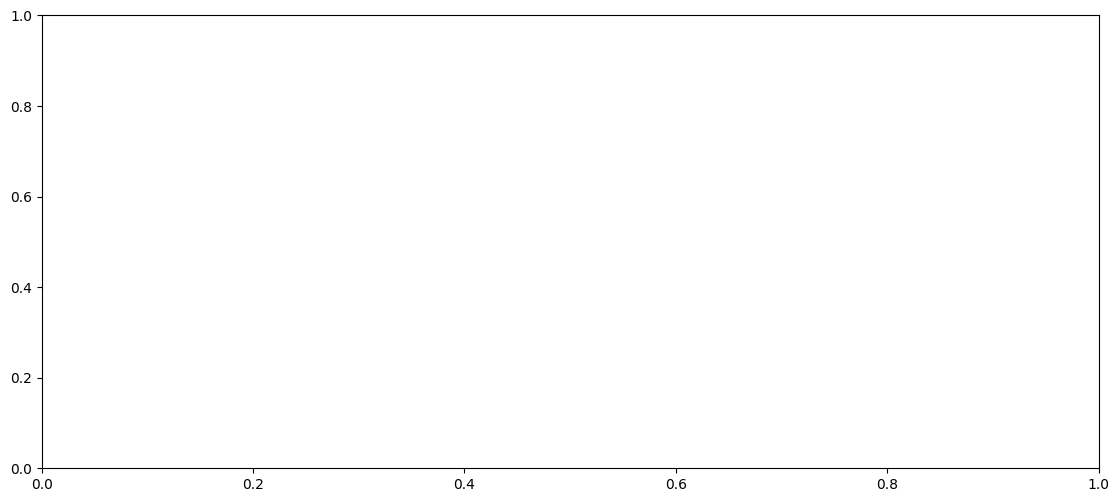

In [421]:
# narysujmy teraz poszczególne kroki jeden pod drugim

plt.figure(figsize=(30, 20))

plt.subplot(321)
plot_decision_boundaries(clf_1, X)

plt.subplot(322)
plot_decision_boundaries(clf_2, X)

plt.subplot(323)
plot_decision_boundaries(clf_3, X)

plt.subplot(324)
plot_decision_boundaries(clf_300, X)
plt.show()

In [422]:
# KMeans vs MiniBatchKMeans

# import odpowiedniej biblioteki
from sklearn.cluster import KMeans, MiniBatchKMeans

# K-means CLustering
from sklearn.cluster import MiniBatchKMeans

%timeit

# metoda MiniBatchKMeans
MBKMeans_clf = MiniBatchKMeans(n_clusters=6, max_iter=10, random_state=1)
%timeit MBKMeans_clf.fit(X)

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `

450 ms ± 24.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [423]:
from sklearn.cluster import KMeans

%timeit

# metoda KMeans
KMeans_clf = KMeans(n_clusters=6, max_iter=10, random_state=1)
%timeit KMeans_clf.fit(X)

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

2.01 s ± 59.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [424]:
#1 Tworzymy 19 algorytmów z k od 1 do 19
kmeans_per_k = [
    KMeans(n_clusters=k, random_state=2).fit(X)
    for k in range(2, 20) # zaczynamy od wartości n_clusters wynoszącej 2, gdyż nie ma sensu dzielenia zbioru dla 1 klastra
]

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

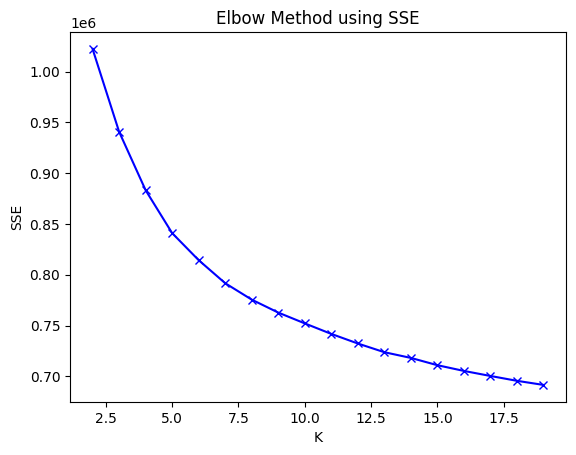

In [425]:
import matplotlib.pyplot as plt
inertias = [model.inertia_ for model in kmeans_per_k]
plt.plot(range(2, 20), inertias, 'bx-')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow Method using SSE')
plt.show()

In [426]:
#2. Używamy tzw silhouette_score

from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k]

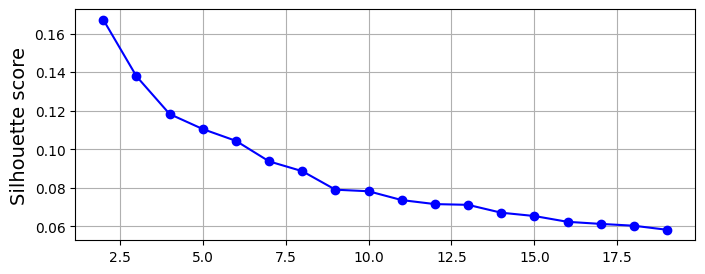

In [427]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 20), silhouette_scores, "bo-")
plt.ylabel("Silhouette score", fontsize=14)
plt.grid()
plt.show()

In [428]:
# KMeans jako preprocessing danych

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Użyj prostego klasyfikatora LogisticRegression, aby przewidzieć jaką cyfrę przedstawia 
# obrazek i wypisz uzyskany wynik (użyj multi_class="ovr")
log_reg = LogisticRegression(multi_class="ovr", max_iter=5000, random_state=2)
log_reg.fit(X_train, y_train)
print("Bez KMeans :", log_reg.score(X_test, y_test))

# Utwórz pipeline składający się z: 
# - KMeansClustering z ilością klastrów znacznie większą od ilości klas w zbiorze 
# (w praktyce o wiele lepiej działa stworzenie większej ilości klastrów niż chcemy 
# przewidzieć klas) 
# - oraz LogisticRegression
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=40, random_state=2)),
    ("log_reg", LogisticRegression(multi_class="ovr", max_iter=5000, random_state=2)),
])

# Naucz taki pipeline i wypisz wynik
pipeline.fit(X_train, y_train)
print("Z KMeans :", pipeline.score(X_test, y_test))

Bez KMeans : 0.8606796116504855


c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Z KMeans : 0.6436893203883495


#### Widać, że akurat w tym przypadku użycie preprocessingu w postaci KMeans nie powoduje poprawienia wyniku.

In [429]:
#DBSCAN

from sklearn.cluster import DBSCAN

# tworzymy pierwszy klasyfikator DBSCAN z eps = 0.05
dbscan = DBSCAN(eps=0.05, min_samples=6)
dbscan.fit(X)

# drugi DBSCAN z eps = 0.2 (większy epsilon, większa przestrzeń wokół)
dbscan_2 = DBSCAN(eps=0.2, min_samples=6)
dbscan_2.fit(X)

DBSCAN(eps=0.2, min_samples=6)

In [430]:
def plot_dbscan(dbscan, X, size):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], 
                marker=".")
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), 
                fontsize=14)

InvalidIndexError: (slice(None, None, None), 0)

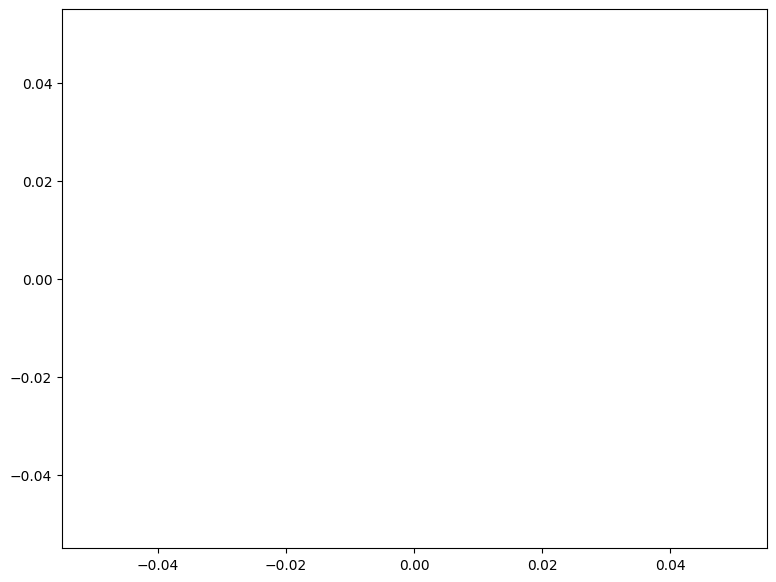

In [431]:
plt.figure(figsize=(20, 7))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan_2, X, size=600)

plt.show()

In [432]:
KMeans_clf = KMeans(n_clusters=2, max_iter=100000)
KMeans_clf.fit(X)

plot_decision_boundaries(KMeans_clf, X)

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ValueError: X has 2 features, but KMeans is expecting 922 features as input.

In [433]:
# Gaussian Mixture Models (GNN)

from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

In [434]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

# metoda zaporzyczona z przykładów sklearn oraz lekko zmodyfikowana 
def plot_gaussian_mixture(clf, X, resolution=1000):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clf.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, linewidths=3, colors='b')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

    plt.xlabel("$x_1$", fontsize=14)
    plt.tick_params(labelleft=False)

In [435]:
plt.figure(figsize=(16, 8))

plot_gaussian_mixture(gm, X)
plt.show()

ValueError: X has 2 features, but GaussianMixture is expecting 922 features as input.

<Figure size 1600x800 with 0 Axes>

In [436]:
gm.converged_

True

In [437]:
gm.n_iter_

12

In [438]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42, covariance_type="full")
gm.fit(X)
plt.figure(figsize=(16, 8))

plot_gaussian_mixture(gm, X)
plt.show()

ValueError: X has 2 features, but GaussianMixture is expecting 922 features as input.

<Figure size 1600x800 with 0 Axes>

In [439]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42, covariance_type="tied")
gm.fit(X)
plt.figure(figsize=(16, 8))

plot_gaussian_mixture(gm, X)
plt.show()

ValueError: X has 2 features, but GaussianMixture is expecting 922 features as input.

<Figure size 1600x800 with 0 Axes>

In [440]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42, covariance_type="diag")
gm.fit(X)
plt.figure(figsize=(16, 8))

plot_gaussian_mixture(gm, X)
plt.show()

ValueError: X has 2 features, but GaussianMixture is expecting 922 features as input.

<Figure size 1600x800 with 0 Axes>

In [444]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42, covariance_type="spherical")
gm.fit(X)
plt.figure(figsize=(16, 8))

plot_gaussian_mixture(gm, X)
plt.show()

ValueError: X has 2 features, but GaussianMixture is expecting 922 features as input.

<Figure size 1600x800 with 0 Axes>

In [445]:
# GMM jako wykrywacz anomalii

gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

plt.figure(figsize=(16, 8))

plot_gaussian_mixture(gm, X)

# odsiewanie anomalii
# Pobieramy wartości dla naszego zbioru, które
# mówią nam, jak bardzo element należy do klastrów
density = gm.score_samples(X)

# Tworzymy wartość graniczną, czyli threshold. 
# Wartości, które mają wyniki z poprzedniej linii mniejsze od naszego threshold, 
# są anomaliami, więc zostają odsiane
# W naszym przypadku chcemy odsiać 5% najgorszych wartości
threshold = np.percentile(density, 5)

# Odsiewamy te wartości poprzez proste porównanie
anomalie = X[density < threshold]

plt.scatter(anomalie[:, 0], anomalie[:, 1], color='y', marker='o')
plt.show()

ValueError: X has 2 features, but GaussianMixture is expecting 922 features as input.

<Figure size 1600x800 with 0 Axes>